# Работа с собственным датасетом c Drom.ru

In [1]:
#Импортируем необходимые библиотеки для работы
import glob
import shutil
import json
import os
import time
import pickle as pk

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter, defaultdict

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2

In [2]:
CLASS_INDEX = None
CLASS_INDEX_PATH = './data/imagenet_class_index.json'

# Методы для фильтрации исходных датасетов

In [3]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [4]:
def get_predictions(preds, top=10):
    global CLASS_INDEX
    
    CLASS_INDEX = json.load(open(CLASS_INDEX_PATH))
    
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

Получаем теги, по которым смотрим на принадлежность файла к классу машин

In [5]:
def get_object_tags(dir_path: str):
    
    img_list = glob.glob(f"{dir_path}/*.jpg")
    d = defaultdict(float)
    
    for i, file_path in enumerate(img_list):
        img = prepare_image(file_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 100 == 0:
            print (i, '/', len(img_list), 'complete')
        BACKUP_VAR = Counter(d)
    return Counter(d)

Метод для определения машины по пути и списку тегов

In [6]:
def object_categories_gate(image_path, tags) -> int:
    img = prepare_image(image_path)
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    for j in top[0]:
        if j[0:2] in tags:
            return True
    return False

## Фильтрация исходного датасета машин

Используем VGG16 с их датасетом

In [7]:
vgg16 = VGG16(weights='imagenet')
vgg16.save('./data/vgg16.h5')

2022-04-13 23:03:51.817659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-13 23:03:51.817773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


Если еще нет тегов, по которым определяем машины - закидываем все фотки VGG16 и берем оттуда все теги, иначе просто загружаем их из файла

In [8]:
tags_counter = None

#Если еще нет файла с тегами, то генерируем все теги
if not os.path.exists("./data/car_tags_counter.pk"):
    tags_counter = get_object_tags('./dumps/photos')
    with open('./data/car_tags_counter.pk', 'wb') as f:
        pk.dump(tags_counter,f,-1)

#Если уже есть файл с тегами, то просто грузим его
else:
    with open('./data/car_tags_counter.pk', 'rb') as f:
        tags_counter = pk.load(f)

Наиболее распространенные теги для машин

In [9]:
car_tags_list = [k for k, v in tags_counter.most_common()[:27]]
car_tags_list

[('n03770679', 'minivan'),
 ('n02814533', 'beach_wagon'),
 ('n03100240', 'convertible'),
 ('n03670208', 'limousine'),
 ('n04285008', 'sports_car'),
 ('n04252225', 'snowplow'),
 ('n03594945', 'jeep'),
 ('n04252077', 'snowmobile'),
 ('n04037443', 'racer'),
 ('n03930630', 'pickup'),
 ('n03769881', 'minibus'),
 ('n02974003', 'car_wheel'),
 ('n02930766', 'cab'),
 ('n03459775', 'grille'),
 ('n04461696', 'tow_truck'),
 ('n03796401', 'moving_van'),
 ('n03977966', 'police_van'),
 ('n03478589', 'half_track'),
 ('n02704792', 'amphibian'),
 ('n04065272', 'recreational_vehicle'),
 ('n03445924', 'golfcart'),
 ('n02701002', 'ambulance'),
 ('n03791053', 'motor_scooter'),
 ('n06359193', 'web_site'),
 ('n03841143', 'odometer'),
 ('n02860847', 'bobsled'),
 ('n03417042', 'garbage_truck')]

Чистим от предыдущих результатов распознавания, если они есть

In [10]:
if os.path.exists("./dumps/photos_detected"):
    shutil.rmtree("./dumps/photos_detected")
if not os.path.exists("./dumps/photos_detected"):
    os.mkdir("./dumps/photos_detected")
    os.mkdir("./dumps/photos_detected/car")
    os.mkdir("./dumps/photos_detected/not_car")

In [11]:
files_list = glob.glob("./dumps/photos/*.jpg")
list_len = len(files_list)
counter = 1
for image_path in files_list:
    image_name = image_path.split("/")[-1]
    if object_categories_gate(image_path, car_tags_list) is True:
        shutil.copyfile(image_path, "./dumps/photos_detected/car/"+image_name)
    else:
        shutil.copyfile(image_path, "./dumps/photos_detected/not_car/"+image_name)
        
    if counter % 100 == 0:
        print(f"{counter}/{list_len}")
    
    counter += 1

2022-04-13 23:03:55.134228: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-13 23:03:55.178433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


100/35094
200/35094
300/35094
400/35094
500/35094
600/35094
700/35094
800/35094
900/35094
1000/35094
1100/35094
1200/35094
1300/35094
1400/35094
1500/35094
1600/35094
1700/35094
1800/35094
1900/35094
2000/35094
2100/35094
2200/35094
2300/35094
2400/35094
2500/35094
2600/35094
2700/35094
2800/35094
2900/35094
3000/35094
3100/35094
3200/35094
3300/35094
3400/35094
3500/35094
3600/35094
3700/35094
3800/35094
3900/35094
4000/35094
4100/35094
4200/35094
4300/35094
4400/35094
4500/35094
4600/35094
4700/35094
4800/35094
4900/35094
5000/35094
5100/35094
5200/35094
5300/35094
5400/35094
5500/35094
5600/35094
5700/35094
5800/35094
5900/35094
6000/35094
6100/35094
6200/35094
6300/35094
6400/35094
6500/35094
6600/35094
6700/35094
6800/35094
6900/35094
7000/35094
7100/35094
7200/35094
7300/35094
7400/35094
7500/35094
7600/35094
7700/35094
7800/35094
7900/35094
8000/35094
8100/35094
8200/35094
8300/35094
8400/35094
8500/35094
8600/35094
8700/35094
8800/35094
8900/35094
9000/35094
9100/35094
9200/350

Удаляем с JSON те файлы, на которых нет изображения

In [7]:
def new_path_fix(path: str) -> str:
    return path.replace("/photos/","/photos_detected/car/")

In [8]:
filtered_cars_dict = {}
with open("./dumps/all/all_cars.json", "r") as f:
    cars_dict = json.loads(f.read())

In [9]:
for key, data in cars_dict.items():
    if data["mainPhoto"] is not None:
        path = new_path_fix(data["mainPhoto"][0]["url"])
        data["mainPhoto"][0]["url"] = path
        
        if os.path.exists(path):
            filtered_cars_dict[key] = data

In [10]:
filtered_cars_len = len(filtered_cars_dict)
print(f"{len(cars_dict)-filtered_cars_len} записей отфильтровано\nОсталось {filtered_cars_len} значений")

784 записей отфильтровано
Осталось 34747 значений


Сохраняем отфильтрованные значения

In [11]:
with open("./dumps/all/all_cars_filtered.json", "w") as f:
    f.write(json.dumps(filtered_cars_dict))

### Делаем распределение по моделям машин

In [12]:
path = "./dumps/by_model"
with open("./dumps/all/all_cars_filtered.json", "r") as f:
    car_data = json.loads(f.read())

if not os.path.exists(path):
    os.mkdir(path)

items_len = len(car_data)
counter = 1
firms_set = set()
for key, data in car_data.items():
    firm_id = data["firmId"]
    old_path = data["mainPhoto"][0]["url"]
    img_name = old_path.split("/")[-1]
    new_path = f"{path}/{firm_id}/{img_name}"
    

    if not os.path.exists(f"{path}/{firm_id}"):
        os.mkdir(f"{path}/{firm_id}")
    
    if not os.path.exists(f"{path}/{firm_id}"):
        os.mkdir(f"{path}/{firm_id}")
    
    firms_set.add(firm_id)
    shutil.copyfile(old_path, new_path)
   
    if counter % 100 == 0:
        print(f"{counter}/{items_len}")
    
    counter += 1

100/34747
200/34747
300/34747
400/34747
500/34747
600/34747
700/34747
800/34747
900/34747
1000/34747
1100/34747
1200/34747
1300/34747
1400/34747
1500/34747
1600/34747
1700/34747
1800/34747
1900/34747
2000/34747
2100/34747
2200/34747
2300/34747
2400/34747
2500/34747
2600/34747
2700/34747
2800/34747
2900/34747
3000/34747
3100/34747
3200/34747
3300/34747
3400/34747
3500/34747
3600/34747
3700/34747
3800/34747
3900/34747
4000/34747
4100/34747
4200/34747
4300/34747
4400/34747
4500/34747
4600/34747
4700/34747
4800/34747
4900/34747
5000/34747
5100/34747
5200/34747
5300/34747
5400/34747
5500/34747
5600/34747
5700/34747
5800/34747
5900/34747
6000/34747
6100/34747
6200/34747
6300/34747
6400/34747
6500/34747
6600/34747
6700/34747
6800/34747
6900/34747
7000/34747
7100/34747
7200/34747
7300/34747
7400/34747
7500/34747
7600/34747
7700/34747
7800/34747
7900/34747
8000/34747
8100/34747
8200/34747
8300/34747
8400/34747
8500/34747
8600/34747
8700/34747
8800/34747
8900/34747
9000/34747
9100/34747
9200/347

In [13]:
print(f" Всего {len(firms_set)} классов фирм-производителей")

 Всего 90 классов фирм-производителей


# Предварительный анализ данных

In [14]:
df = pd.read_json("./dumps/all/all_cars_filtered.json").transpose()
df.head()

,id,url,cityId,regionId,firmId,modelId,countryId,isOwner,isOwnerSells,priceCategory,...,mainPhoto,thumbnails,auctionInfo,pretty,complectation,viewsCount,viewsTotal,minPrice,isQuestionAllowed,ownershipPeriodsCount
45230658,45230658,https://novosibirsk.drom.ru/toyota/alphard/452...,109,54,9,2466,None,None,False,3,...,"[{'id': '714313137', 'url': './dumps/photos_de...","[[{'id': '714313137', 'url': 'https://s.auto.d...",None,"{'firm': 'Toyota', 'model': 'Alphard', 'countr...","{'name': 'Hybrid 2.5 X 4WD (7 Seater)', 'url':...",1509,None,None,False,None
45628684,45628684,https://novosibirsk.drom.ru/kia/rio/45628684.html,109,54,59,3169,None,None,False,6,...,"[{'id': '728465080', 'url': './dumps/photos_de...","[[{'id': '728465080', 'url': 'https://s.auto.d...",None,"{'firm': 'Kia', 'model': 'Rio', 'country': 'Ро...",None,1457,None,None,False,None
45630218,45630218,https://novosibirsk.drom.ru/nissan/juke/456302...,109,54,6,3892,None,None,False,2,...,"[{'id': '728511044', 'url': './dumps/photos_de...","[[{'id': '728511044', 'url': 'https://s.auto.d...",None,"{'firm': 'Nissan', 'model': 'Juke', 'country':...","{'name': '1.6 CVT 2WD LE Perso', 'url': 'https...",205,None,None,False,None
44339378,44339378,https://novosibirsk.drom.ru/bmw/x5/44339378.html,109,54,33,2842,None,None,True,2,...,"[{'id': '685691690', 'url': './dumps/photos_de...","[[{'id': '685691690', 'url': 'https://s.auto.d...",None,"{'firm': 'BMW', 'model': 'X5', 'country': 'Рос...","{'name': 'xDrive M50d AT', 'url': 'https://www...",559,None,None,False,None
45630116,45630116,https://novosibirsk.drom.ru/mercedes-benz/c-cl...,109,54,67,3236,None,None,False,None,...,"[{'id': '728506676', 'url': './dumps/photos_de...","[[{'id': '728506676', 'url': 'https://s.auto.d...",None,"{'firm': 'Mercedes-Benz', 'model': 'C-Class', ...",None,1425,None,None,False,None


In [15]:
df.dtypes

id                          object
url                         object
cityId                      object
regionId                    object
firmId                      object
modelId                     object
countryId                   object
isOwner                     object
isOwnerSells                object
priceCategory               object
ownerType                   object
dealerId                    object
price                       object
currency                    object
year                        object
engineVolume                object
enginePower                 object
notUsedInRussia             object
mileageKm                   object
fuelType                    object
isHybrid                    object
isGboExists                 object
driveType                   object
transmissionType            object
modificationTransmission    object
wheel                       object
frameType                   object
hasVinInfo                  object
colorId             

Название фирмы-производителя пишем в отдельный столбец

In [16]:
def extracter(value):
    value["firm_name"] = value["pretty"]["firm"]
    return value
df = df.apply(lambda x: extracter(x), axis=1)

In [17]:
df.head()

,id,url,cityId,regionId,firmId,modelId,countryId,isOwner,isOwnerSells,priceCategory,...,thumbnails,auctionInfo,pretty,complectation,viewsCount,viewsTotal,minPrice,isQuestionAllowed,ownershipPeriodsCount,firm_name
45230658,45230658,https://novosibirsk.drom.ru/toyota/alphard/452...,109,54,9,2466,None,None,False,3.0,...,"[[{'id': '714313137', 'url': 'https://s.auto.d...",None,"{'firm': 'Toyota', 'model': 'Alphard', 'countr...","{'name': 'Hybrid 2.5 X 4WD (7 Seater)', 'url':...",1509,None,NaN,False,None,Toyota
45628684,45628684,https://novosibirsk.drom.ru/kia/rio/45628684.html,109,54,59,3169,None,None,False,6.0,...,"[[{'id': '728465080', 'url': 'https://s.auto.d...",None,"{'firm': 'Kia', 'model': 'Rio', 'country': 'Ро...",None,1457,None,NaN,False,None,Kia
45630218,45630218,https://novosibirsk.drom.ru/nissan/juke/456302...,109,54,6,3892,None,None,False,2.0,...,"[[{'id': '728511044', 'url': 'https://s.auto.d...",None,"{'firm': 'Nissan', 'model': 'Juke', 'country':...","{'name': '1.6 CVT 2WD LE Perso', 'url': 'https...",205,None,NaN,False,None,Nissan
44339378,44339378,https://novosibirsk.drom.ru/bmw/x5/44339378.html,109,54,33,2842,None,None,True,2.0,...,"[[{'id': '685691690', 'url': 'https://s.auto.d...",None,"{'firm': 'BMW', 'model': 'X5', 'country': 'Рос...","{'name': 'xDrive M50d AT', 'url': 'https://www...",559,None,NaN,False,None,BMW
45630116,45630116,https://novosibirsk.drom.ru/mercedes-benz/c-cl...,109,54,67,3236,None,None,False,NaN,...,"[[{'id': '728506676', 'url': 'https://s.auto.d...",None,"{'firm': 'Mercedes-Benz', 'model': 'C-Class', ...",None,1425,None,NaN,False,None,Mercedes-Benz


In [18]:
firm_series = df.groupby("firm_name")["id"].count()
firm_dict = firm_series.to_dict()

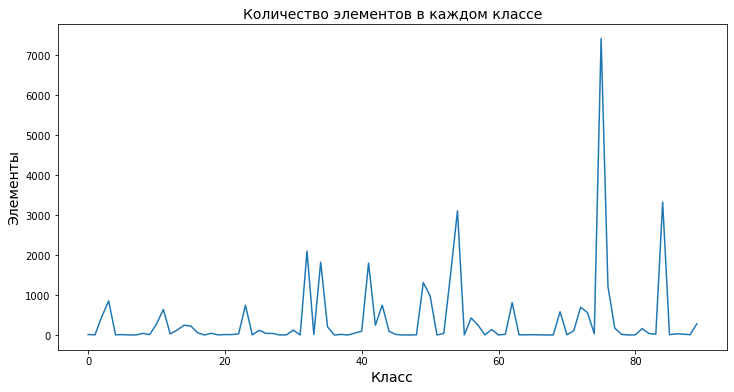

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

x = firm_dict.keys()
y = firm_dict.values()

ax.plot(y)
ax.set_title('Количество элементов в каждом классе', fontsize=14)
ax.set_xlabel('Класс', fontsize=14)
ax.set_ylabel('Элементы', fontsize=14)

plt.savefig('./img/model.png')
plt.show()

Смотрим наименее распространенные фиры автопроизводителей

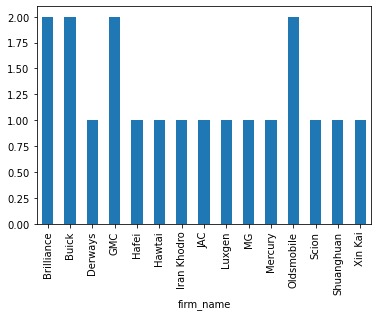

In [20]:
firm_series[firm_series < 3].plot(kind="bar")
plt.savefig('./img/min.png', bbox_inches='tight')

Смотрим наиболее распространенные фиры автопроизводителей

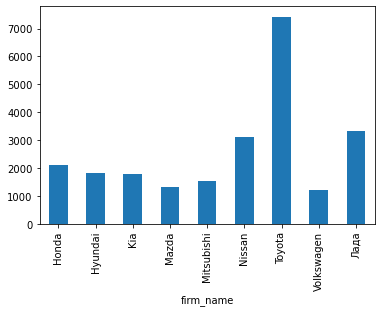

In [21]:
firm_series[firm_series > 1000].plot(kind="bar")
popular_firms = []
plt.savefig('./img/max.png', bbox_inches='tight')

Формируем список наиболее популярных фирм

In [22]:
popular_models_list = list(firm_series[firm_series > 1000].to_dict().keys())
popular_models_list

['Honda',
 'Hyundai',
 'Kia',
 'Mazda',
 'Mitsubishi',
 'Nissan',
 'Toyota',
 'Volkswagen',
 'Лада']

#### Подправляем датасет, чтоб в каждом классе было одинаковое кол-во элементов

In [23]:
popular_model_pattern = "|".join(popular_models_list)
df_fixed = df[df['firm_name'].str.contains(popular_model_pattern)==True]
df_fixed

,id,url,cityId,regionId,firmId,modelId,countryId,isOwner,isOwnerSells,priceCategory,...,thumbnails,auctionInfo,pretty,complectation,viewsCount,viewsTotal,minPrice,isQuestionAllowed,ownershipPeriodsCount,firm_name
45230658,45230658,https://novosibirsk.drom.ru/toyota/alphard/452...,109,54,9,2466,None,None,False,3.0,...,"[[{'id': '714313137', 'url': 'https://s.auto.d...",None,"{'firm': 'Toyota', 'model': 'Alphard', 'countr...","{'name': 'Hybrid 2.5 X 4WD (7 Seater)', 'url':...",1509,None,NaN,False,None,Toyota
45628684,45628684,https://novosibirsk.drom.ru/kia/rio/45628684.html,109,54,59,3169,None,None,False,6.0,...,"[[{'id': '728465080', 'url': 'https://s.auto.d...",None,"{'firm': 'Kia', 'model': 'Rio', 'country': 'Ро...",None,1457,None,NaN,False,None,Kia
45630218,45630218,https://novosibirsk.drom.ru/nissan/juke/456302...,109,54,6,3892,None,None,False,2.0,...,"[[{'id': '728511044', 'url': 'https://s.auto.d...",None,"{'firm': 'Nissan', 'model': 'Juke', 'country':...","{'name': '1.6 CVT 2WD LE Perso', 'url': 'https...",205,None,NaN,False,None,Nissan
45302355,45302355,https://novosibirsk.drom.ru/nissan/stagea/4530...,109,54,6,199,None,None,False,NaN,...,"[[{'id': '716628280', 'url': 'https://s.auto.d...",None,"{'firm': 'Nissan', 'model': 'Stagea', 'country...",None,543,None,NaN,False,None,Nissan
45630054,45630054,https://novosibirsk.drom.ru/nissan/cube/456300...,109,54,6,286,None,None,False,11.0,...,"[[{'id': '729188385', 'url': 'https://s.auto.d...",None,"{'firm': 'Nissan', 'model': 'Cube', 'country':...",None,507,None,NaN,False,None,Nissan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45955710,45955710,https://habarovsk.drom.ru/toyota/wish/45955710...,173,27,9,2523,None,None,True,3.0,...,"[[{'id': '739541703', 'url': 'https://s.auto.d...",None,"{'firm': 'Toyota', 'model': 'Wish', 'country':...","{'name': '1.8 X aero Sports package', 'url': '...",51,None,NaN,True,None,Toyota
45168709,45168709,https://habarovsk.drom.ru/nissan/cube/45168709...,173,27,6,286,None,None,False,4.0,...,"[[{'id': '712256396', 'url': 'https://s.auto.d...",None,"{'firm': 'Nissan', 'model': 'Cube', 'country':...",{'name': '1.5 Rider high performance spec plus...,46,None,NaN,True,None,Nissan
45696236,45696236,https://habarovsk.drom.ru/toyota/bb/45696236.html,173,27,9,315,None,None,False,6.0,...,"[[{'id': '731027349', 'url': 'https://s.auto.d...",None,"{'firm': 'Toyota', 'model': 'bB', 'country': '...",None,24,None,NaN,True,None,Toyota
45708285,45708285,https://habarovsk.drom.ru/honda/fit/45708285.html,173,27,2,1084,None,None,False,3.0,...,"[[{'id': '731525235', 'url': 'https://s.auto.d...",None,"{'firm': 'Honda', 'model': 'Fit', 'country': '...","{'name': '1.3 G', 'url': 'https://www.drom.ru/...",36,None,NaN,True,None,Honda


In [24]:
new_series = df_fixed.groupby("firm_name")["id"].count()
new_series

firm_name
Honda         2100
Hyundai       1824
Kia           1801
Mazda         1313
Mitsubishi    1532
Nissan        3110
Toyota        7426
Volkswagen    1220
Лада          3326
Name: id, dtype: int64

Ориентируясь самый малочисленный класс среди наиболее популярных, формируем кол-во необходимвых данных в каждом классе

In [25]:
min_series_count = min(new_series)
min_series_count

1220

In [26]:
final_df = pd.DataFrame()

In [27]:
for firm in popular_models_list:
    buf_df = df_fixed[df_fixed["firm_name"] == firm][:min_series_count]
    final_df = pd.concat([final_df, buf_df], ignore_index=True, sort=False)

Проверка данных

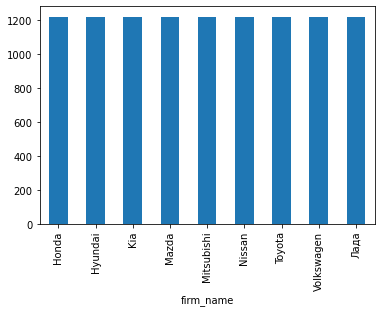

In [28]:
final_df.groupby("firm_name")["id"].count().plot(kind="bar")
plt.savefig('./img/normal.png', bbox_inches='tight')

In [29]:
final_df.shape

(10980, 57)

In [30]:
set(final_df["firmId"].to_list())

{2, 4, 5, 6, 9, 56, 59, 89, 99}

In [31]:
set(final_df["firm_name"].to_list())

{'Honda',
 'Hyundai',
 'Kia',
 'Mazda',
 'Mitsubishi',
 'Nissan',
 'Toyota',
 'Volkswagen',
 'Лада'}

In [32]:
final_df.to_json('./dumps/all/all_cars_filtered_final.json')

# Сама работа с изображениями

### 1. Переводим все изображения в формат матрицы

In [33]:
files_list = glob.glob("./dumps/photos_detected/car/*.jpg")

In [34]:
def show_img(index=0):
    plt.imshow(cv2.imread(files_list[index], cv2.IMREAD_UNCHANGED))

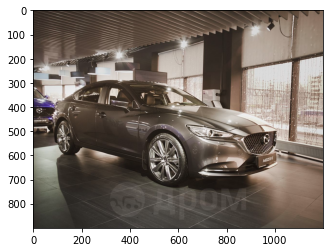

In [35]:
show_img()

### 2. Уменьшаем размеры

In [36]:
row_number, column_number = 64, 64

100/34748
200/34748
300/34748
400/34748
500/34748
600/34748
700/34748
800/34748
900/34748
1000/34748
1100/34748
1200/34748
1300/34748
1400/34748
1500/34748
1600/34748
1700/34748
1800/34748
1900/34748
2000/34748
2100/34748
2200/34748
2300/34748
2400/34748
2500/34748
2600/34748
2700/34748
2800/34748
2900/34748
3000/34748
3100/34748
3200/34748
3300/34748
3400/34748
3500/34748
3600/34748
3700/34748
3800/34748
3900/34748
4000/34748
4100/34748
4200/34748
4300/34748
4400/34748
4500/34748
4600/34748
4700/34748
4800/34748
4900/34748
5000/34748
5100/34748
5200/34748
5300/34748
5400/34748
5500/34748
5600/34748
5700/34748
5800/34748
5900/34748
6000/34748
6100/34748
6200/34748
6300/34748
6400/34748
6500/34748
6600/34748
6700/34748
6800/34748
6900/34748
7000/34748
7100/34748
7200/34748
7300/34748
7400/34748
7500/34748
7600/34748
7700/34748
7800/34748
7900/34748
8000/34748
8100/34748
8200/34748
8300/34748
8400/34748
8500/34748
8600/34748
8700/34748
8800/34748
8900/34748
9000/34748
9100/34748
9200/347

Premature end of JPEG file


33200/34748
33300/34748
33400/34748
33500/34748
33600/34748
33700/34748
33800/34748
33900/34748
34000/34748
34100/34748
34200/34748
34300/34748
34400/34748
34500/34748
34600/34748
34700/34748


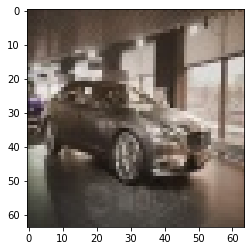

In [37]:
files_len = len(files_list)
counter = 1
for file in files_list:
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, (row_number, column_number), interpolation = cv2.INTER_AREA)
    cv2.imwrite(file, resized) 
    
    if counter % 100 == 0:
        print(f"{counter}/{files_len}")

    counter += 1

show_img()

### 3. Переводим в черно-белый формат

100/34748
200/34748
300/34748
400/34748
500/34748
600/34748
700/34748
800/34748
900/34748
1000/34748
1100/34748
1200/34748
1300/34748
1400/34748
1500/34748
1600/34748
1700/34748
1800/34748
1900/34748
2000/34748
2100/34748
2200/34748
2300/34748
2400/34748
2500/34748
2600/34748
2700/34748
2800/34748
2900/34748
3000/34748
3100/34748
3200/34748
3300/34748
3400/34748
3500/34748
3600/34748
3700/34748
3800/34748
3900/34748
4000/34748
4100/34748
4200/34748
4300/34748
4400/34748
4500/34748
4600/34748
4700/34748
4800/34748
4900/34748
5000/34748
5100/34748
5200/34748
5300/34748
5400/34748
5500/34748
5600/34748
5700/34748
5800/34748
5900/34748
6000/34748
6100/34748
6200/34748
6300/34748
6400/34748
6500/34748
6600/34748
6700/34748
6800/34748
6900/34748
7000/34748
7100/34748
7200/34748
7300/34748
7400/34748
7500/34748
7600/34748
7700/34748
7800/34748
7900/34748
8000/34748
8100/34748
8200/34748
8300/34748
8400/34748
8500/34748
8600/34748
8700/34748
8800/34748
8900/34748
9000/34748
9100/34748
9200/347

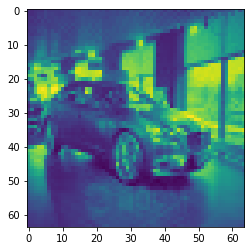

In [38]:
counter = 1
for file in files_list:
    img = cv2.imread(file,cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(file, img) 
    
    if counter % 100 == 0:
        print(f"{counter}/{files_len}")
    
    counter += 1
    
show_img()

### 4. Формирование факторов

In [39]:
final_df = pd.read_json("./dumps/all/all_cars_filtered_final.json")
final_df.head()

,id,url,cityId,regionId,firmId,modelId,countryId,isOwner,isOwnerSells,priceCategory,...,thumbnails,auctionInfo,pretty,complectation,viewsCount,viewsTotal,minPrice,isQuestionAllowed,ownershipPeriodsCount,firm_name
0,45930001,https://novosibirsk.drom.ru/honda/stepwgn/4593...,109,54,2,291,NaN,NaN,False,3.0,...,"[[{'id': '738701154', 'url': 'https://s.auto.d...",NaN,"{'firm': 'Honda', 'model': 'Stepwgn', 'country...",None,59,NaN,NaN,True,NaN,Honda
1,46026079,https://krasnodar.drom.ru/honda/fit/46026079.html,75,23,2,1084,NaN,NaN,False,NaN,...,"[[{'id': '741691886', 'url': 'https://s.auto.d...",NaN,"{'firm': 'Honda', 'model': 'Fit', 'country': '...","{'name': '1.5 RS', 'url': 'https://www.drom.ru...",88,NaN,NaN,True,NaN,Honda
2,45892667,https://barnaul.drom.ru/honda/fit/45892667.html,11,22,2,1084,NaN,NaN,False,3.0,...,"[[{'id': '737600815', 'url': 'https://s.auto.d...",NaN,"{'firm': 'Honda', 'model': 'Fit', 'country': '...",None,323,NaN,NaN,False,NaN,Honda
3,43747110,https://krasnodar.drom.ru/honda/cr-v/43747110....,75,23,2,173,NaN,NaN,False,3.0,...,"[[{'id': '686087060', 'url': 'https://s.auto.d...",NaN,"{'firm': 'Honda', 'model': 'CR-V', 'country': ...","{'name': '2.0 AT Elegance', 'url': 'https://ww...",38,NaN,NaN,False,NaN,Honda
4,45935493,https://habarovsk.drom.ru/honda/insight/459354...,173,27,2,356,NaN,NaN,False,3.0,...,"[[{'id': '738933480', 'url': 'https://s.auto.d...",NaN,"{'firm': 'Honda', 'model': 'Insight', 'country...","{'name': '1.5 Exclusive XL InterNavi Select', ...",235,NaN,NaN,True,NaN,Honda


In [40]:
final_df.shape

(10980, 57)

In [41]:
IMAGES_DATA = np.zeros(shape=(final_df.shape[0],row_number*column_number))
IMAGES_DATA.shape

(10980, 4096)

In [42]:
counter = 0
for index, row in final_df.iterrows():
    x = row["firmId"]
    url = row["mainPhoto"][0]["url"]
    img = cv2.imread(url, cv2.IMREAD_UNCHANGED)
    IMAGES_DATA[counter] = img.flatten()
    counter += 1

In [43]:
IMAGES_DATA

array([[108., 115., 120., ...,  94.,  99.,  96.],
       [138., 134., 135., ..., 197., 196., 191.],
       [238., 247., 150., ...,  88., 107., 107.],
       ...,
       [163., 162., 161., ..., 120., 115., 119.],
       [143., 145., 146., ..., 129., 151., 147.],
       [146., 150., 148., ..., 181., 192., 194.]])

Нормализация матриц

In [44]:
IMAGES_DATA = IMAGES_DATA / 255
IMAGES_DATA

array([[0.42352941, 0.45098039, 0.47058824, ..., 0.36862745, 0.38823529,
        0.37647059],
       [0.54117647, 0.5254902 , 0.52941176, ..., 0.77254902, 0.76862745,
        0.74901961],
       [0.93333333, 0.96862745, 0.58823529, ..., 0.34509804, 0.41960784,
        0.41960784],
       ...,
       [0.63921569, 0.63529412, 0.63137255, ..., 0.47058824, 0.45098039,
        0.46666667],
       [0.56078431, 0.56862745, 0.57254902, ..., 0.50588235, 0.59215686,
        0.57647059],
       [0.57254902, 0.58823529, 0.58039216, ..., 0.70980392, 0.75294118,
        0.76078431]])

## Работа в sklearn

Делим данные на тестовую и обучающую выборки

In [49]:
X = IMAGES_DATA
Y = final_df["firmId"].to_numpy()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [51]:
# Реализация метода опорных векторов через SVC
from sklearn import svm

start_time = time.time()
nb = svm.SVC().fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

           2       0.18      0.29      0.22       244
           4       0.61      0.27      0.38       244
           5       0.41      0.31      0.35       244
           6       0.17      0.15      0.16       244
           9       0.16      0.24      0.19       244
          56       0.24      0.15      0.18       244
          59       0.34      0.32      0.33       244
          89       0.25      0.19      0.22       244
          99       0.18      0.26      0.21       244

    accuracy                           0.24      2196
   macro avg       0.28      0.24      0.25      2196
weighted avg       0.28      0.24      0.25      2196

Время выполнения 361.42729592323303


In [52]:
#Реализация наивного байесовского метода
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()
nb = MultinomialNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

           2       0.13      0.09      0.10       244
           4       0.19      0.29      0.23       244
           5       0.14      0.08      0.10       244
           6       0.15      0.07      0.09       244
           9       0.14      0.36      0.20       244
          56       0.17      0.11      0.13       244
          59       0.18      0.35      0.23       244
          89       0.10      0.01      0.02       244
          99       0.13      0.07      0.10       244

    accuracy                           0.16      2196
   macro avg       0.15      0.16      0.14      2196
weighted avg       0.15      0.16      0.14      2196

Время выполнения 0.3001840114593506


In [53]:
# Реализация метода k-ближайших соседей
import sklearn.neighbors as neigh

start_time = time.time()
kn = neigh.KNeighborsClassifier(n_neighbors=90, n_jobs=6).fit(X_train,y_train)
y_pred = kn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

           2       0.17      0.24      0.20       244
           4       0.42      0.27      0.33       244
           5       0.32      0.17      0.22       244
           6       0.21      0.11      0.15       244
           9       0.14      0.20      0.16       244
          56       0.24      0.09      0.13       244
          59       0.25      0.36      0.29       244
          89       0.18      0.11      0.13       244
          99       0.15      0.31      0.20       244

    accuracy                           0.21      2196
   macro avg       0.23      0.21      0.20      2196
weighted avg       0.23      0.21      0.20      2196

Время выполнения 3.189142942428589


In [54]:
# Реализация метода опорных векторов через LinearSVC
import sklearn.svm as svm

start_time = time.time()
svect = svm.LinearSVC(max_iter=5000).fit(X_train, y_train)
y_pred = svect.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

           2       0.19      0.17      0.18       244
           4       0.36      0.37      0.36       244
           5       0.28      0.34      0.31       244
           6       0.13      0.14      0.13       244
           9       0.15      0.15      0.15       244
          56       0.19      0.16      0.17       244
          59       0.20      0.20      0.20       244
          89       0.15      0.15      0.15       244
          99       0.15      0.16      0.16       244

    accuracy                           0.20      2196
   macro avg       0.20      0.20      0.20      2196
weighted avg       0.20      0.20      0.20      2196

Время выполнения 2500.5840051174164


/Users/demg/miniforge3/envs/env_tf/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [55]:
# Реализация логистической регресси
from sklearn.linear_model import LogisticRegression

start_time = time.time()
logr = LogisticRegression(max_iter=5000, n_jobs=6).fit(X_train, y_train)
y_pred = logr.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

           2       0.18      0.17      0.17       244
           4       0.40      0.38      0.39       244
           5       0.30      0.34      0.32       244
           6       0.16      0.17      0.17       244
           9       0.14      0.13      0.14       244
          56       0.16      0.14      0.15       244
          59       0.21      0.20      0.21       244
          89       0.15      0.16      0.16       244
          99       0.14      0.15      0.14       244

    accuracy                           0.21      2196
   macro avg       0.21      0.21      0.20      2196
weighted avg       0.21      0.21      0.20      2196

Время выполнения 534.2075750827789


In [56]:
# Реализация метода случайного леса RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

start_time = time.time()
max_depth = [1,5,10,50]
n_estimators = [5,10,100,500]
grid_params ={'max_depth':max_depth,'n_estimators':n_estimators}
rf = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), grid_params,
                  scoring = 'accuracy', cv=10,n_jobs=6, return_train_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

           2       0.18      0.32      0.23       244
           4       0.65      0.30      0.41       244
           5       0.42      0.30      0.35       244
           6       0.17      0.15      0.16       244
           9       0.14      0.22      0.17       244
          56       0.24      0.16      0.19       244
          59       0.35      0.34      0.34       244
          89       0.23      0.20      0.21       244
          99       0.21      0.24      0.22       244

    accuracy                           0.25      2196
   macro avg       0.29      0.25      0.25      2196
weighted avg       0.29      0.25      0.25      2196

Время выполнения 1340.826164007187


In [57]:
# Реализация линейного классификатора с SGD-обучением 
import math
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

start_time = time.time()
alpha = [10**x for x in range(-4,4)]
penalty = ["l1","l2"]
grid_params ={'alpha':alpha,'penalty':penalty}
alpha_log = [math.log(x,10) for x in grid_params["alpha"]]
sgd = GridSearchCV(SGDClassifier(class_weight= 'balanced'), grid_params, scoring = 'accuracy', cv=10,n_jobs=6, return_train_score=True)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print("Время выполнения", (time.time()-start_time))

              precision    recall  f1-score   support

           2       0.26      0.08      0.12       244
           4       0.44      0.32      0.37       244
           5       0.24      0.36      0.29       244
           6       0.10      0.01      0.02       244
           9       0.13      0.18      0.15       244
          56       0.21      0.15      0.18       244
          59       0.37      0.14      0.21       244
          89       0.20      0.09      0.12       244
          99       0.14      0.48      0.21       244

    accuracy                           0.20      2196
   macro avg       0.23      0.20      0.19      2196
weighted avg       0.23      0.20      0.19      2196

Время выполнения 1431.2448830604553
